In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import LeaveOneOut, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score


In [2]:
data = pd.read_csv('../data/data.csv')

In [3]:
X,y = data.drop('Estado al egreso', axis=1), data['Estado al egreso']

We are performing nested cross-validation to fairly compare multiple models on a very small dataset (21 samples). For each model (Random Forest, Logistic Regression, etc.), we use Leave-One-Out (LOO) as the outer loop: in each iteration, 20 samples are used for training and 1 for testing. Within the training set, we perform hyperparameter tuning using GridSearchCV with a small inner cross-validation (e.g., 3-fold) to select the best parameters. The best model from the inner loop is then evaluated on the left-out sample. This process repeats 21 times (once per sample) to collect all predictions. Finally, we compute metrics (like F1-score) from these predictions.

This method prevents overfitting by ensuring that:

1. Hyperparameter tuning never sees the test sample.

2. Each model is evaluated on every sample exactly once, under identical conditions.

3. Models are kept simple via constrained hyperparameter grids to avoid over-optimizing on limited data.

### RandomForestClassifier

In [4]:
from sklearn.ensemble import RandomForestClassifier

loo = LeaveOneOut()

rf = RandomForestClassifier(random_state=1, class_weight='balanced')

params_rf = {
    'n_estimators': [10, 20, 30],
    'max_depth': [2, 3],          
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [5, 10]
}

rf_preds = []
y_true_rf = []

for train_idx, test_idx in loo.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    grid_rf = GridSearchCV(rf, params_rf, cv=3, scoring='f1')
    grid_rf.fit(X_train, y_train)
    
    y_pred = grid_rf.best_estimator_.predict(X_test)
    rf_preds.append(y_pred[0])
    y_true_rf.append(y_test.values[0])

f1_rf = f1_score(y_true_rf, rf_preds)
precision_rf = precision_score(y_true_rf, rf_preds, zero_division=0)
recall_rf = recall_score(y_true_rf, rf_preds)

print(f"RandomForest F1: {f1_rf:.3f}, Precision: {precision_rf:.3f}, Recall: {recall_rf:.3f}")

RandomForest F1: 0.923, Precision: 0.923, Recall: 0.923


In [6]:
best_rf = grid_rf.best_estimator_
best_rf

RandomForestClassifier(class_weight='balanced', max_depth=2, min_samples_leaf=3,
                       min_samples_split=10, n_estimators=20, random_state=1)

### LogisticRegression

In [7]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=1, max_iter=10000)

params_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1], 
    'solver': ['saga'],
}

lr_preds = []
y_true_lr = []

for train_idx, test_idx in loo.split(X):

    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

    grid_lr = GridSearchCV(lr, params_lr, cv=3, scoring='f1', n_jobs=-1)
    grid_lr.fit(X_train, y_train)

    y_pred = grid_lr.best_estimator_.predict(X_test)
    lr_preds.append(y_pred[0])
    y_true_lr.append(y_test.values[0])

f1_lr = f1_score(y_true_lr, lr_preds)
precision_lr = precision_score(y_true_lr, lr_preds, zero_division=0)
recall_lr = recall_score(y_true_lr, lr_preds)

print(f"LogisticRegression - F1: {f1_lr:.3f}, Precision: {precision_lr:.3f}, Recall: {recall_lr:.3f}")

LogisticRegression - F1: 0.889, Precision: 0.857, Recall: 0.923


In [9]:
best_lr = grid_lr.best_estimator_
best_lr

LogisticRegression(C=0.1, max_iter=10000, random_state=1, solver='saga')

### DecisionTree

In [10]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=1, class_weight='balanced')

params_dt = {
    'max_depth': [2, 3, 6],
    'min_samples_leaf': [2, 4, 6],
    'min_samples_split': [2, 4],
    'criterion': ['gini', 'entropy']
}

dt_preds = []
y_true_dt = []

for train_idx, test_idx in loo.split(X):

    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

    grid_dt = GridSearchCV(dt, params_dt, cv=3, scoring='f1', n_jobs=-1)
    grid_dt.fit(X_train, y_train)

    y_pred = grid_dt.best_estimator_.predict(X_test)
    dt_preds.append(y_pred[0])
    y_true_dt.append(y_test.values[0])

f1_dt = f1_score(y_true_dt, dt_preds)
precision_dt = precision_score(y_true_dt, dt_preds, zero_division=0)
recall_dt = recall_score(y_true_dt, dt_preds)

print(f"DecisionTree - F1: {f1_dt:.3f}, Precision: {precision_dt:.3f}, Recall: {recall_dt:.3f}")

DecisionTree - F1: 0.696, Precision: 0.800, Recall: 0.615


In [12]:
best_dt = grid_dt.best_estimator_
best_dt

DecisionTreeClassifier(class_weight='balanced', max_depth=2, min_samples_leaf=4,
                       random_state=1)

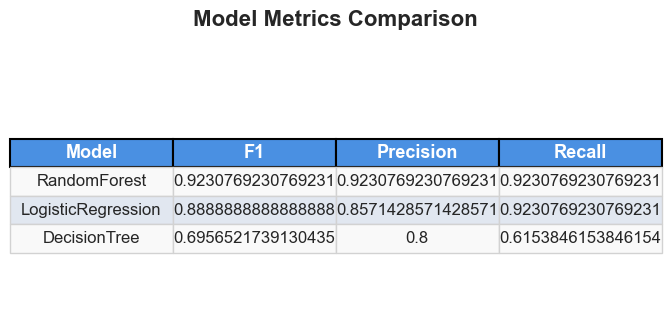

In [13]:
metrics = {
    'Model': ['RandomForest', 'LogisticRegression', 'DecisionTree'],
    'F1': [f1_rf, f1_lr, f1_dt],
    'Precision': [precision_rf, precision_lr, precision_dt],
    'Recall': [recall_rf, recall_lr, recall_dt]
}
               
df = pd.DataFrame(metrics)

sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(7, 3.5)) 

ax.axis('off')

table = ax.table(cellText=df.values,
                 colLabels=df.columns,
                 cellLoc='center',
                 loc='center',
                 colWidths=[0.25]*4)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.3, 1.8)

for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold', color='white', fontsize=13)
        cell.set_facecolor('#4a90e2')
        cell.set_linewidth(1.5)
        cell.set_edgecolor('black')
    else:
        bg_color = '#f9f9f9' if row % 2 == 1 else '#e1e7f0'
        cell.set_facecolor(bg_color)
        cell.set_linewidth(1)
        cell.set_edgecolor("#D2D2D2")
        cell.get_text().set_multialignment('center')

plt.title('Model Metrics Comparison', fontsize=16, weight='bold', pad=30)

plt.tight_layout()
plt.show()


In [22]:
import pickle as pkl

with open('../models/rf.pkl', 'wb') as file:
    pkl.dump(best_rf, file)


with open('../models/lr.pkl', 'wb') as file:
    pkl.dump(best_lr, file)
